## Import data

In [4]:
%matplotlib inline
%reload_ext autoreload
from rtxlib.rtx_run import setup_database, db
from analysis_lib.one_sample_tests import KolmogorovSmirnov
from factorial_anova_analysis import get_raw_data

index = "rtxgaussian-600-300-baseline-4iter-2" 

results = get_raw_data(index, False, 5000)

data retrieved from file rtxgaussian-600-300-baseline-4iter-2-5000.pickle


In [5]:
import pprint
from IPython.display import Markdown, display

def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
pp = pprint.PrettyPrinter(indent=4)

knobs = {}
data = {}
for r in results:
    knob_str = str(r[1])
    if not knob_str in knobs:        
        knobs[knob_str] = []
    if len(knobs[knob_str]) < 5000:
        knobs[knob_str].append(r[1])
    if not knob_str in data:        
        data[knob_str] = []
    if len(data[knob_str]) < 5000:
        data[knob_str].append(r[0])

printmd("**Found " + str(len(knobs)) + " different configurations in " + str(len(results)) + " data **", "green")

for k in knobs:
    print str(len(knobs[k])) + " of these:"
    pp.pprint(eval(k))
    print "\n"

<span style='color:green'>**Found 4 different configurations in 20000 data **</span>

5000 of these:
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 20,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}


5000 of these:
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.0,
    u'freshness_cut_off_value': 100,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.3}


5000 of these:
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 20,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 70,
    u'route_random_sigma': 0.0}


5000 of these:
{   u'average_edge_duration_factor': 1.064940627681949,
    u'exploration_percentage': 0.02028517375112562,
    u'freshness_cut_off_value': 365,
    u'freshness_upd

## Ttests with variable sample sizes

In [6]:
from analysis_lib.two_sample_tests import Ttest
from analysis_lib.two_sample_tests import TtestPower
from complaints_generator import generate_complaints
from scipy.stats import binom_test
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("savefig", dpi=150)
import random 
from IPython.display import Markdown, display

def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))
    
random.seed(123456)

y_key = 'overhead'
alpha = 0.05
necessary_power = 0.80

fake_run_id = "123456"

knob_values = knobs.keys()
best_knob = knob_values[0]
other_knob_values = knob_values[1:] 

sample_sizes = []
pvalues = {}
powers = {}

for i in knob_values:
    pvalues[i] = []
    powers[i] = []
        
step = 100

count = 0
for other_knob_value in other_knob_values:   
    for sample_size in range(100, 5001, step):
    #     print "Sample size: " + str(sample_size)
        sample_sizes.append(sample_size)

        analysis_data = {}
        raw_data = data[best_knob] 
#         analysis_data[0] = raw_data[:sample_size] #  also: 
        analysis_data[0] = random.sample(raw_data, sample_size)
  
        raw_data = data[other_knob_value] 
#         analysis_data[1] = raw_data[:sample_size] #  also: 
        analysis_data[1] = random.sample(raw_data, sample_size)
          
        t = Ttest(fake_run_id, y_key, alpha).start(analysis_data, {})
        pvalues[other_knob_value].append(t["pvalue"])
        one_sided_p_value = t["pvalue"]/2
        
        if t["statistic"] < 0:
            t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'smaller').start(analysis_data, {})            
        else: 
            t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'larger').start(analysis_data, {})            
        powers[other_knob_value].append(t_p["power"])
        
        if one_sided_p_value < alpha and t_p["power"] >= necessary_power:
            printmd("**SIGNIFICANT DIFFERENCE**", "green")
            different = "smaller" if t["statistic"] < 0 else "larger"
            print "sample size: " + str(sample_size) 
            print "================"
            print "Overhead in " 
            pp.pprint(eval(best_knob))
            print " is " + different + " than in "
            pp.pprint(eval(other_knob_value))
            print "================"
            print "mean difference: " + str(t["mean_diff"]) 
            print "p value: " + str(one_sided_p_value)                                 
            print "effect size: " + str(t["effect_size"]) 
            print "power: " + str(t_p["power"])
            print "\n"
            
            count += 1
            if t["statistic"] >= 0:
                best_knob = other_knob_value
            break

        if sample_size == 5000:
            printmd("**NO SIGNIFICANT DIFFERENCE**", "red")
            different = "smaller" if t["statistic"] < 0 else "larger"
            print "sample size: " + str(sample_size) 
            print "================"
            print "Overhead in " 
            pp.pprint(eval(best_knob))
            print " is " + different + " than in "
            pp.pprint(eval(other_knob_value))
            print "================"
            print "mean difference: " + str(t["mean_diff"]) 
            print "p value: " + str(one_sided_p_value)                                 
            print "effect size: " + str(t["effect_size"]) 
            print "power: " + str(t_p["power"])
            print "\n"
        
print str(count) + " out of " + str(len(other_knob_values)) + " comparisons found significant difference."
print "******************"
print "BEST CONFIGURATION"
print "******************"
pp.pprint(knobs[best_knob][0])


<span style='color:green'>**SIGNIFICANT DIFFERENCE**</span>

sample size: 200
Overhead in 
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 20,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}
 is smaller than in 
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.0,
    u'freshness_cut_off_value': 100,
    u'freshness_update_factor': 5,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.3}
mean difference: -0.297789775606
p value: 0.000189116599606
effect size: -0.359496344142
power: 0.97405165493




<span style='color:red'>**NO SIGNIFICANT DIFFERENCE**</span>

sample size: 5000
Overhead in 
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 20,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}
 is smaller than in 
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 20,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 70,
    u'route_random_sigma': 0.0}
mean difference: -0.00037433701129
p value: 0.489600779365
effect size: -0.000521463873783
power: 0.0527470669566




<span style='color:red'>**NO SIGNIFICANT DIFFERENCE**</span>

sample size: 5000
Overhead in 
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 20,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}
 is smaller than in 
{   u'average_edge_duration_factor': 1.064940627681949,
    u'exploration_percentage': 0.02028517375112562,
    u'freshness_cut_off_value': 365,
    u'freshness_update_factor': 8,
    u'max_speed_and_length_factor': 2.029578786016287,
    u're_route_every_ticks': 54,
    u'route_random_sigma': 0.2760877094817076}
mean difference: -0.0162956535523
p value: 0.15288510333
effect size: -0.0204858800327
power: 0.267421903053


1 out of 3 comparisons found significant difference.
******************
BEST CONFIGURATION
******************
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 20,
    

In [7]:
results = get_raw_data("rtxgaussian-600-300-2-5iter", False, 5000)

b_knobs = {}
b_data = {}
for r in results:
    knob_str = str(r[1])
    if not knob_str in b_knobs:        
        b_knobs[knob_str] = []
    if len(b_knobs[knob_str]) < 5000:
        b_knobs[knob_str].append(r[1])
    if not knob_str in b_data:        
        b_data[knob_str] = []
    if len(b_data[knob_str]) < 5000:
        b_data[knob_str].append(r[0])

print "len(knobs):" + str(len(b_knobs))

for k in b_knobs:
    print k
    print len(b_knobs[k])

print "========="

data retrieved from file rtxgaussian-600-300-2-5iter-5000.pickle
len(knobs):2
{u'freshness_cut_off_value': 700}
5000
{u'freshness_cut_off_value': 180}
5000


In [8]:
knobs2 = b_knobs.copy()
data2 = b_data.copy()

b_knobs[best_knob] = knobs[best_knob]
b_data[best_knob] = data[best_knob]

print "len(knobs):" + str(len(b_knobs))

for k in b_knobs:
    print k
    print len(b_knobs[k])

print "========="

len(knobs):3
{u're_route_every_ticks': 10, u'freshness_cut_off_value': 700, u'max_speed_and_length_factor': 1.0, u'exploration_percentage': 0.3, u'freshness_update_factor': 20, u'route_random_sigma': 0.0, u'average_edge_duration_factor': 2.5}
5000
{u'freshness_cut_off_value': 700}
5000
{u'freshness_cut_off_value': 180}
5000


In [10]:
y_key = 'overhead'
alpha = 0.05
necessary_power = 0.80

fake_run_id = "123456"

knob_values = b_knobs.keys()
best_knob2 = knob_values[0]
other_knob_values = knob_values[1:] 

sample_sizes = []
pvalues = {}
powers = {}

for i in knob_values:
    pvalues[i] = []
    powers[i] = []
        
step = 100

count = 0
for other_knob_value in other_knob_values:   
    for sample_size in range(100, 5001, step):
    #     print "Sample size: " + str(sample_size)
        sample_sizes.append(sample_size)

        analysis_data = {}
        raw_data = b_data[best_knob2] 
#         analysis_data[0] = raw_data[:sample_size] #  also: 
        analysis_data[0] = random.sample(raw_data, sample_size)
  
        raw_data = b_data[other_knob_value] 
#         analysis_data[1] = raw_data[:sample_size] #  also: 
        analysis_data[1] = random.sample(raw_data, sample_size)
          
        t = Ttest(fake_run_id, y_key, alpha).start(analysis_data, {})
        pvalues[other_knob_value].append(t["pvalue"])
        one_sided_p_value = t["pvalue"]/2
        
        if t["statistic"] < 0:
            t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'smaller').start(analysis_data, {})            
        else: 
            t_p = TtestPower(fake_run_id, y_key, t["effect_size"], alpha, 'larger').start(analysis_data, {})            
        powers[other_knob_value].append(t_p["power"])
        
        if one_sided_p_value < alpha and t_p["power"] >= necessary_power:
            printmd("**SIGNIFICANT DIFFERENCE**", "green")
            different = "smaller" if t["statistic"] < 0 else "larger"
            print "sample size: " + str(sample_size) 
            print "================"
            print "Overhead in " 
            pp.pprint(eval(best_knob2))
            print " is " + different + " than in "
            pp.pprint(eval(other_knob_value))
            print "================"
            print "mean difference: " + str(t["mean_diff"]) 
            print "p value: " + str(one_sided_p_value)                                 
            print "effect size: " + str(t["effect_size"]) 
            print "power: " + str(t_p["power"])
            print "\n"
            
            count += 1
            if t["statistic"] >= 0:
                best_knob2 = other_knob_value
            break
        
        if sample_size == 5000:
            printmd("**NO SIGNIFICANT DIFFERENCE**", "red")
            different = "smaller" if t["statistic"] < 0 else "larger"
            print "sample size: " + str(sample_size) 
            print "================"
            print "Overhead in " 
            pp.pprint(eval(best_knob2))
            print " is " + different + " than in "
            pp.pprint(eval(other_knob_value))
            print "================"
            print "mean difference: " + str(t["mean_diff"]) 
            print "p value: " + str(one_sided_p_value)                                 
            print "effect size: " + str(t["effect_size"]) 
            print "power: " + str(t_p["power"])
            print "\n"

print str(count) + " out of " + str(len(other_knob_values)) + " comparisons found significant difference."
print "******************"
print "BEST CONFIGURATION"
print "******************"
pp.pprint(b_knobs[best_knob2][0])

<span style='color:green'>**SIGNIFICANT DIFFERENCE**</span>

sample size: 200
Overhead in 
{   u'average_edge_duration_factor': 2.5,
    u'exploration_percentage': 0.3,
    u'freshness_cut_off_value': 700,
    u'freshness_update_factor': 20,
    u'max_speed_and_length_factor': 1.0,
    u're_route_every_ticks': 10,
    u'route_random_sigma': 0.0}
 is larger than in 
{   u'freshness_cut_off_value': 700}
mean difference: 0.16232382824
p value: 0.00403026805635
effect size: 0.267051384572
power: 0.846400495892




<span style='color:green'>**SIGNIFICANT DIFFERENCE**</span>

sample size: 100
Overhead in 
{   u'freshness_cut_off_value': 700}
 is smaller than in 
{   u'freshness_cut_off_value': 180}
mean difference: -0.260931972605
p value: 0.00597804286065
effect size: -0.360578435318
power: 0.814898768971


2 out of 2 comparisons found significant difference.
******************
BEST CONFIGURATION
******************
{   u'freshness_cut_off_value': 700}


In [11]:
results = get_raw_data("rtxgaussian-600-300-1-5iter", False, 5000)

knobs1 = {}
data1 = {}
for r in results:
    knob_str = str(r[1])
    if not knob_str in knobs1:        
        knobs1[knob_str] = []
    if len(knobs1[knob_str]) < 5000:
        knobs1[knob_str].append(r[1])
    if not knob_str in data1:        
        data1[knob_str] = []
    if len(data1[knob_str]) < 5000:
        data1[knob_str].append(r[0])

print "len(knobs):" + str(len(knobs1))

for k in knobs1:
    print k
    print len(knobs1[k])

print "========="

data retrieved from file rtxgaussian-600-300-1-5iter-5000.pickle
len(knobs):2
{u'max_speed_and_length_factor': 2.4999884040123677}
5000
{u'max_speed_and_length_factor': 1.0}
5000


In [12]:
for k in knobs:
    print k
    print len(knobs[k])

print "*************"

for k in knobs1:
    print k
    print len(knobs1[k])

for k in knobs2:
    print k
    print len(knobs2[k])

{u're_route_every_ticks': 10, u'freshness_cut_off_value': 700, u'max_speed_and_length_factor': 1.0, u'exploration_percentage': 0.3, u'freshness_update_factor': 20, u'route_random_sigma': 0.0, u'average_edge_duration_factor': 2.5}
5000
{u're_route_every_ticks': 10, u'freshness_cut_off_value': 100, u'max_speed_and_length_factor': 1.0, u'exploration_percentage': 0.0, u'freshness_update_factor': 5, u'route_random_sigma': 0.3, u'average_edge_duration_factor': 2.5}
5000
{u're_route_every_ticks': 70, u'freshness_cut_off_value': 700, u'max_speed_and_length_factor': 1.0, u'exploration_percentage': 0.3, u'freshness_update_factor': 20, u'route_random_sigma': 0.0, u'average_edge_duration_factor': 2.5}
5000
{u're_route_every_ticks': 54, u'freshness_cut_off_value': 365, u'max_speed_and_length_factor': 2.029578786016287, u'exploration_percentage': 0.02028517375112562, u'freshness_update_factor': 8, u'route_random_sigma': 0.2760877094817076, u'average_edge_duration_factor': 1.064940627681949}
5000
***

0
{u're_route_every_ticks': 10, u'freshness_cut_off_value': 700, u'max_speed_and_length_factor': 1.0, u'exploration_percentage': 0.3, u'freshness_update_factor': 20, u'route_random_sigma': 0.0, u'average_edge_duration_factor': 2.5}
******
1
{u're_route_every_ticks': 10, u'freshness_cut_off_value': 100, u'max_speed_and_length_factor': 1.0, u'exploration_percentage': 0.0, u'freshness_update_factor': 5, u'route_random_sigma': 0.3, u'average_edge_duration_factor': 2.5}
******
2
{u're_route_every_ticks': 70, u'freshness_cut_off_value': 700, u'max_speed_and_length_factor': 1.0, u'exploration_percentage': 0.3, u'freshness_update_factor': 20, u'route_random_sigma': 0.0, u'average_edge_duration_factor': 2.5}
******
3
{u're_route_every_ticks': 54, u'freshness_cut_off_value': 365, u'max_speed_and_length_factor': 2.029578786016287, u'exploration_percentage': 0.02028517375112562, u'freshness_update_factor': 8, u'route_random_sigma': 0.2760877094817076, u'average_edge_duration_factor': 1.06494062768

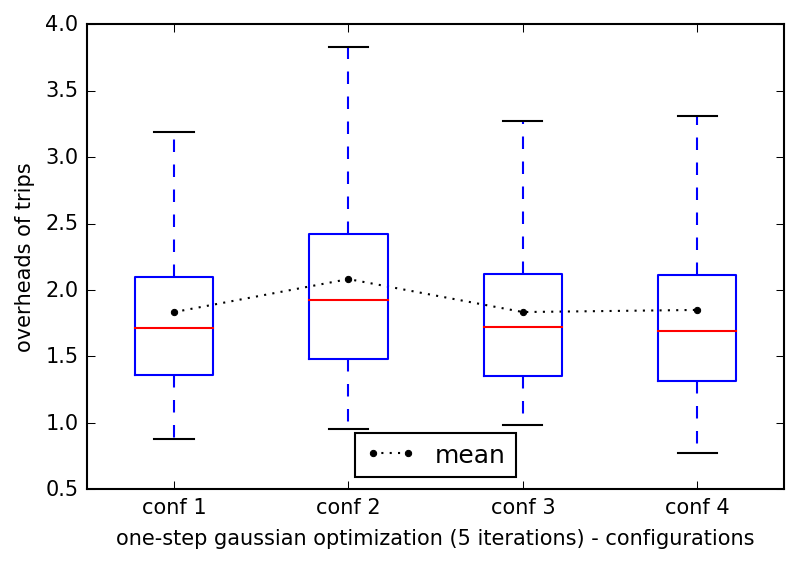

In [13]:
import matplotlib.pyplot as plt
from numpy import var, std, mean, median
import matplotlib as mpl
mpl.rc("savefig", dpi=150)

y_key = 'overhead'

means = []
all_data = []

knob_labels = []
i = 0
for k in knobs: 
    print i
    print k
    print "******"
    knob_labels.append(i)
    i += 1
    
# knob_labels = [i for i in range(len(knobs))]

for k in knobs:
    analysis_data = [r[y_key] for r in data[k]]
    all_data.append(analysis_data)
    means.append(mean(analysis_data))

fig,ax = plt.subplots()
ax.plot(knob_labels,means, ".", label='mean', color="black", linestyle=":")
ax.boxplot(all_data, 0, '', positions=knob_labels)
#     ax.boxplot(all_data, 0, '', positions=keys)
plt.xticks(knob_labels, ["conf 1", "conf 2", "conf 3", "conf 4", "conf 5"])
plt.legend(loc='lower center')
plt.ylabel('overheads of trips')
plt.xlabel('one-step gaussian optimization (5 iterations) - configurations')
plt.show()

0
{u'max_speed_and_length_factor': 2.4999884040123677}
******
1
{u'max_speed_and_length_factor': 1.0}
******
2
{u'freshness_cut_off_value': 180}
******
3
{u'freshness_cut_off_value': 700}
******


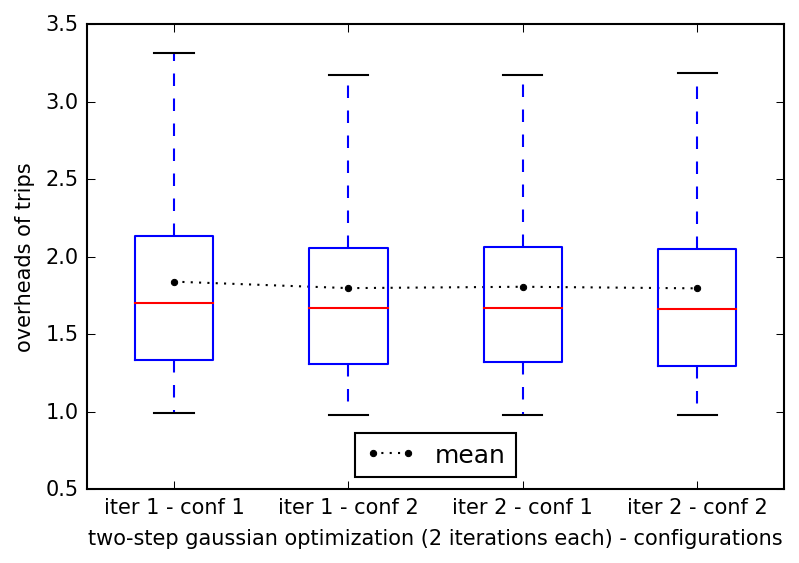

In [14]:
means2 = []
all_data = []

knob_labels = []
i = 0
for k in knobs1: 
    print i
    print k
    print "******"
    knob_labels.append(i)
    i += 1

for k in sorted(knobs2): 
    print i
    print k
    print "******"
    knob_labels.append(i)
    i += 1

# knob_labels = [i for i in range(len(knobs))]

for k in knobs1:
    analysis_data = [r[y_key] for r in data1[k]]
    all_data.append(analysis_data)
    means2.append(mean(analysis_data))

for k in sorted(knobs2):
    analysis_data = [r[y_key] for r in data2[k]]
    all_data.append(analysis_data)
    means2.append(mean(analysis_data))
    
fig,ax = plt.subplots()
ax.plot(knob_labels,means2, ".", label='mean', color="black", linestyle=":")
ax.boxplot(all_data, 0, '', positions=knob_labels)
#     ax.boxplot(all_data, 0, '', positions=keys)
plt.xticks(knob_labels, ["iter 1 - conf 1", "iter 1 - conf 2", "iter 2 - conf 1", "iter 2 - conf 2"])
plt.legend(loc='lower center')
plt.ylabel('overheads of trips')
plt.xlabel('two-step gaussian optimization (2 iterations each) - configurations')
plt.show()

{u're_route_every_ticks': 10, u'freshness_cut_off_value': 700, u'max_speed_and_length_factor': 1.0, u'exploration_percentage': 0.3, u'freshness_update_factor': 20, u'route_random_sigma': 0.0, u'average_edge_duration_factor': 2.5}
{u'freshness_cut_off_value': 700}


/Users/gerostat/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


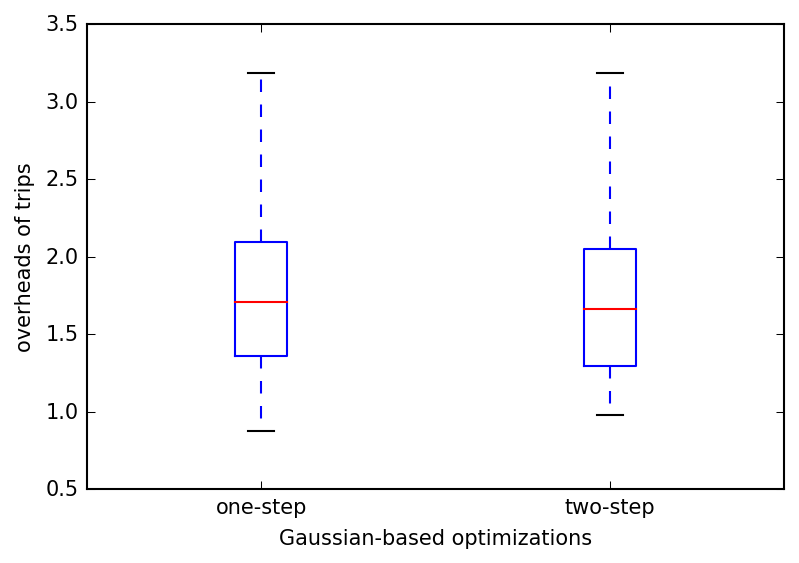

In [15]:
all_data = []
print best_knob
print best_knob2
analysis_data = [r[y_key] for r in data[best_knob]]
all_data.append(analysis_data)

analysis_data = [r[y_key] for r in data2[best_knob2]]
all_data.append(analysis_data)
    
knob_labels = ["one-step", "two-step"]
arithmetic_labels = [0,1]
fig,ax = plt.subplots()
ax.boxplot(all_data, 0, '', positions=arithmetic_labels)
#     ax.boxplot(all_data, 0, '', positions=keys)
plt.xticks(arithmetic_labels, knob_labels)
plt.legend(loc='best')
plt.ylabel('overheads of trips')
plt.xlabel('Gaussian-based optimizations')
plt.show()

[0, 1, 2, 3]


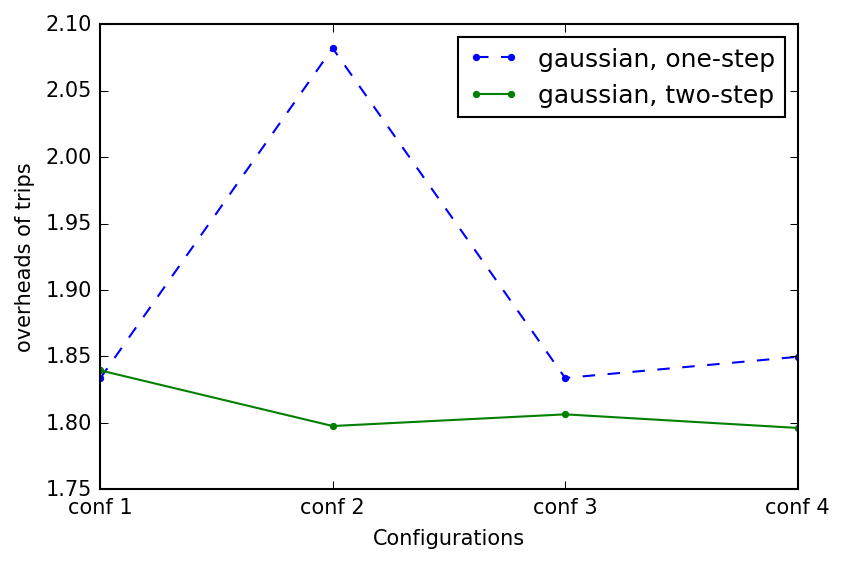

In [16]:
knob_labels = range(4)
print knob_labels
fig,ax = plt.subplots()
ax.plot(knob_labels, means, ".", label='gaussian, one-step', linestyle="--")
ax.plot(knob_labels, means2, ".", label='gaussian, two-step', linestyle="-")
plt.xticks(knob_labels, ["conf 1", "conf 2", "conf 3", "conf 4"])
plt.legend(loc='best')
plt.ylabel('overheads of trips')
plt.xlabel('Configurations')
plt.show()